Ce notebook vise à créer un modèle capable d eprédire l'accidentologie à vélo sur une année par commune de France.

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from xgboost import XGBRegressor

from velosafe.models import grid_search, save_model, stratified_sample

## Data loading

Les données proviennent de différents datasets libres de data.gouv.fr, et peuvent être générées en exécutant `python -m velosafe datagen`. Le résultat sera combiné dans un unique fichier nommé `training_data.csv`.

In [21]:
df = pd.read_csv("../data/training_data.csv")

In [22]:
print(df["code_commune"].unique())

['81233' '48027' '81101' ... '43142' '74290' '26084']


## Data preprocessing

Dans cette phase, nous effectuerons l'étape de data preprocessing, en particulier la sélection des features et le train/test split.

### Filter features

In [15]:
FEATURES = [
    "population",
    "area",
    "accident_num",
    "length",
    "ACCOTEMENT REVETU HORS CVCB",
    "AMENAGEMENT MIXTES PIETON VELO HORS VOIE VERTE",
    "AUTRE",
    "BANDE CYCLABLE",
    "CHAUSSEE A VOIE CENTRALE BANALISEE",
    "COULOIR BUS+VELO",
    "DOUBLE SENS CYCLABLE BANDE",
    "DOUBLE SENS CYCLABLE NON MATERIALISE",
    "DOUBLE SENS CYCLABLE PISTE",
    "GOULOTTE",
    "PISTE CYCLABLE",
    "VELO RUE",
    "VOIE VERTE",
    "road length",
]

df = df[FEATURES]
df.head()

,population,area,accident_num,length,ACCOTEMENT REVETU HORS CVCB,AMENAGEMENT MIXTES PIETON VELO HORS VOIE VERTE,AUTRE,BANDE CYCLABLE,CHAUSSEE A VOIE CENTRALE BANALISEE,COULOIR BUS+VELO,DOUBLE SENS CYCLABLE BANDE,DOUBLE SENS CYCLABLE NON MATERIALISE,DOUBLE SENS CYCLABLE PISTE,GOULOTTE,PISTE CYCLABLE,VELO RUE,VOIE VERTE,road length
0,234,1355,0.0,1625.607995,0.0,1625.607995,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,91911.627353
1,375,1654,0.0,41750.307169,0.0,0.000000,41750.307169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,63595.588555
2,1242,2334,0.0,20727.046260,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19289.721231,1437.325029,0.0,57673.498923
3,1318,3016,0.0,70.520285,0.0,0.000000,70.520285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,18892.794668
4,319,1022,0.0,4816.411348,0.0,4816.411348,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,19033.988232


### Train/test split

La taille des données est très raisonnable et les modèles entraînées resteront assez simples, ce qui rend possible de faire de la validation croisée. Nous créons donc deux jeux de données uniquement, plutôt que de séparer en train/val/test. 15% des données sont conservées pour le test.

Notons que la distribution est fortement asymétrique, ce qui rend un split aléatoire difficile: les données d'entraînement et de test risqueraient de ne pas avoir la même distribution. Nous définissons donc la fonction `stratified_sample`, qui se charge de découper les données d'entrée en bins, et réalise la séparation des données sur chacun de ces derniers.

In [16]:
df_train, df_test = stratified_sample(df, 0.15)

In [19]:
X_train, y_train = df_train[df_train.columns.difference(["accident_num"])], df_train["accident_num"].values
X_test, y_test = df_test[df_test.columns.difference(["accident_num"])], df_test["accident_num"].values
print(X_train.columns)

Index(['ACCOTEMENT REVETU HORS CVCB',
       'AMENAGEMENT MIXTES PIETON VELO HORS VOIE VERTE', 'AUTRE',
       'BANDE CYCLABLE', 'CHAUSSEE A VOIE CENTRALE BANALISEE',
       'COULOIR BUS+VELO', 'DOUBLE SENS CYCLABLE BANDE',
       'DOUBLE SENS CYCLABLE NON MATERIALISE', 'DOUBLE SENS CYCLABLE PISTE',
       'GOULOTTE', 'PISTE CYCLABLE', 'VELO RUE', 'VOIE VERTE', 'area',
       'length', 'population'],
      dtype='object')


## Model selection

Nous évalutons quelle modèles par validation croisée. Une pipeline intégrant la normalisation des données est automatiquement créée par la fonction `grid_search`.

In [10]:
linear_model, linear_perf = grid_search(
    LinearRegression(), {"fit_intercept": [True, False]}, X_train, y_train, scaler=StandardScaler()
)
linear_perf

,params,mean_test_score,std_test_score,mean_train_score,std_train_score
0,{'fit_intercept': True},-2.128441,0.466038,-1.880608,0.087061
1,{'fit_intercept': False},-2.164653,0.463862,-1.918215,0.087705


In [11]:
random_forest_model, random_forest_perf = grid_search(
    RandomForestRegressor(),
    {"n_estimators": [100, 200, 500], "max_depth": [None, 20]},
    X_train,
    y_train,
    scaler=StandardScaler(),
)
random_forest_perf

,params,mean_test_score,std_test_score,mean_train_score,std_train_score
1,"{'max_depth': None, 'n_estimators': 200}",-1.676942,0.299740,-0.652039,0.032765
5,"{'max_depth': 20, 'n_estimators': 500}",-1.679149,0.273711,-0.656468,0.031736
2,"{'max_depth': None, 'n_estimators': 500}",-1.685230,0.273574,-0.648535,0.031827
0,"{'max_depth': None, 'n_estimators': 100}",-1.693994,0.283220,-0.663269,0.013259
4,"{'max_depth': 20, 'n_estimators': 200}",-1.704328,0.292425,-0.668002,0.036117
3,"{'max_depth': 20, 'n_estimators': 100}",-1.707499,0.287138,-0.670236,0.034963


In [12]:
svm_model, svm_perf = grid_search(
    SVR(),
    {"C": [0.7, 0.9, 1.0], "degree": [1, 2, 3], "kernel": ["linear", "rbf"]},
    X_train,
    y_train,
    scaler=StandardScaler(),
)
svm_perf

,params,mean_test_score,std_test_score,mean_train_score,std_train_score
14,"{'C': 1.0, 'degree': 2, 'kernel': 'linear'}",-2.162027,0.265452,-2.146560,0.070566
12,"{'C': 1.0, 'degree': 1, 'kernel': 'linear'}",-2.162027,0.265452,-2.146560,0.070566
16,"{'C': 1.0, 'degree': 3, 'kernel': 'linear'}",-2.162027,0.265452,-2.146560,0.070566
8,"{'C': 0.9, 'degree': 2, 'kernel': 'linear'}",-2.162073,0.265443,-2.146550,0.070585
10,"{'C': 0.9, 'degree': 3, 'kernel': 'linear'}",-2.162073,0.265443,-2.146550,0.070585
6,"{'C': 0.9, 'degree': 1, 'kernel': 'linear'}",-2.162073,0.265443,-2.146550,0.070585
0,"{'C': 0.7, 'degree': 1, 'kernel': 'linear'}",-2.162098,0.265477,-2.146572,0.070592
4,"{'C': 0.7, 'degree': 3, 'kernel': 'linear'}",-2.162098,0.265477,-2.146572,0.070592
2,"{'C': 0.7, 'degree': 2, 'kernel': 'linear'}",-2.162098,0.265477,-2.146572,0.070592
13,"{'C': 1.0, 'degree': 1, 'kernel': 'rbf'}",-2.837496,0.344980,-2.779938,0.073409


In [18]:
xgb_model, xgb_perf = grid_search(
    XGBRegressor(),
    {
        "n_estimators": [100, 300, 500],
        "learning_rate": [
            0.01,
            0.3,
            0.5,
        ],
        "colsample_bytree": [0.8, 1],
        "max_depth": [3, 6, 10],
    },
    X_train,
    y_train,
    scaler=StandardScaler(),
)
xgb_perf

,params,mean_test_score,std_test_score,mean_train_score,std_train_score
9,"{'colsample_bytree': 0.8, 'learning_rate': 0.3...",-1.663295,0.302003,-0.401520,0.016808
10,"{'colsample_bytree': 0.8, 'learning_rate': 0.3...",-1.667974,0.306428,-0.276772,0.007994
11,"{'colsample_bytree': 0.8, 'learning_rate': 0.3...",-1.670710,0.306988,-0.225590,0.005656
2,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",-1.731022,0.285835,-0.774122,0.045155
29,"{'colsample_bytree': 1, 'learning_rate': 0.01,...",-1.731653,0.271854,-0.769795,0.050699
12,"{'colsample_bytree': 0.8, 'learning_rate': 0.3...",-1.736125,0.257566,-0.208602,0.007709
13,"{'colsample_bytree': 0.8, 'learning_rate': 0.3...",-1.739270,0.257636,-0.084829,0.003973
14,"{'colsample_bytree': 0.8, 'learning_rate': 0.3...",-1.740042,0.257681,-0.039638,0.001817
28,"{'colsample_bytree': 1, 'learning_rate': 0.01,...",-1.758050,0.251471,-0.942078,0.062796
1,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",-1.762639,0.265303,-0.950597,0.051667


## Model evaluation

In [52]:
best_model = random_forest_model

In [53]:
mean_squared_error(y_test, best_model.predict(X_test), squared=False)

1.189901719162479

In [55]:
mean_absolute_error(y_test, best_model.predict(X_test))

0.3120708860759494

(-1.0, 15.0)

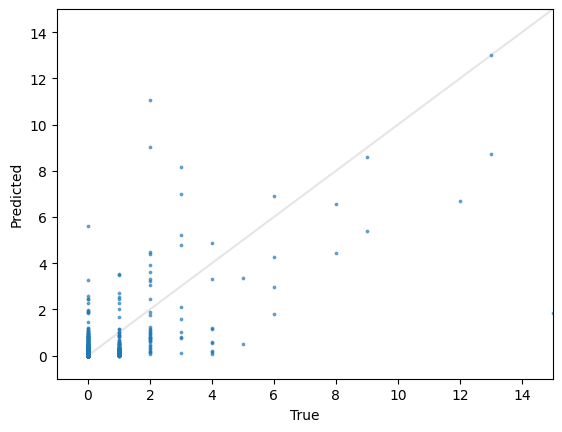

In [60]:
plt.plot(y_test, y_test, color="gray", alpha=0.2)
plt.scatter(y_test, best_model.predict(X_test), s=3, alpha=0.1)
plt.xlabel("Ground truth")
plt.ylabel("Predicted number of accidents")
plt.xlim(-1, 15)
plt.ylim(-1, 15)